# Финальный проект

## Шаг 1

Для начала импортируем необходимые для работы модули

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests as req
import plotly.express as px
from dotenv import load_dotenv
import os



У нас есть два файла. Их необходимо прочитать и записать в переменные.

In [3]:
visits = pd.read_csv("visits_1k.csv")
registrations = pd.read_csv("regs_1k.csv")

Проверим, что все прочиталось верно.

In [4]:
visits.head()

,uuid,platform,user_agent,date
0,1de9ea66-70d3-4a1f-8735-df5ef7697fb9,web,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,2023-03-01T13:29:22
1,f149f542-e935-4870-9734-6b4501eaf614,web,Mozilla/5.0 (X11; CrOS x86_64 8172.45.0) Apple...,2023-03-01T16:44:28
2,f149f542-e935-4870-9734-6b4501eaf614,web,Mozilla/5.0 (X11; CrOS x86_64 8172.45.0) Apple...,2023-03-06T06:12:36
3,08f0ebd4-950c-4dd9-8e97-b5bdf073eed1,web,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:109...,2023-03-01T20:16:37
4,08f0ebd4-950c-4dd9-8e97-b5bdf073eed1,web,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:109...,2023-03-05T17:42:47


In [5]:
registrations.head()

,date,user_id,email,platform,registration_type
0,2023-03-01T00:25:39,8838849,joseph95@example.org,web,google
1,2023-03-01T14:53:01,8741065,janetsuarez@example.net,web,yandex
2,2023-03-01T14:27:36,1866654,robert67@example.org,web,google
3,2023-03-01T02:42:34,1577584,elam@example.net,web,apple
4,2023-03-01T10:27:14,4765395,stephanie68@example.net,web,yandex


На этом шаге, изучим общую информацию о датасетах.

In [6]:
visits.describe()

,uuid,platform,user_agent,date
count,1000,1000,1000,1000
unique,519,3,28,996
top,251a0926-ece3-4d77-aa42-ab569fdf9fe2,web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2023-03-01T08:01:45
freq,4,954,71,2


## Шаг 2

Сделаем запрос по данным в реальном времени по API с 2023-03-01 по 2023-09-01.

Для начала подгрузим переменные окружения. Это необходимо для того, что бы не хардкодить их в ноутбуке и в случае необходимости, поменять их в одном файле.

In [42]:
load_dotenv()

DATE_BEGIN = os.getenv("DATE_BEGIN")
DATE_END   = os.getenv("DATE_END")
API_URL    = os.getenv("API_URL")

print(DATE_BEGIN, DATE_END, API_URL)

2023-03-01 2023-09-01 https://data-charts-api.hexlet.app


Напишем функцию для получения Датафреймов по API

In [43]:
def fetch_df(endpoint: str, begin: str, end: str) -> pd.DataFrame:
    url = f"{API_URL}/{endpoint}"
    params = {"begin": begin, "end": end}
    r = req.get(url, params=params)
    df = pd.DataFrame(r.json())
    return df
    
    


ДатаФрейм визитов

In [ ]:
df_visits = fetch_df("visits", DATE_BEGIN, DATE_END)
df_visits

Датафрейм регистраций

In [ ]:
df_regs = fetch_df("registrations", DATE_BEGIN, DATE_END)
df_regs

# Шаг 3

Нам необходимо рассчитать конверсию из визита в регистрацию. В первую очередь необходимо отсеять SEO ботов из визитов. Для этого создадим булеву маски.

### Подготовка визитов 

В первую очередь необходимо отсеять SEO ботов из визитов. Для этого создадим булеву маски.

In [ ]:
non_bot_mask = ~df_visits['user_agent'].str.contains('bot', case=False, na=False)

применяем маску к Датафрейму visits

In [ ]:
visits_non_bot = df_visits[non_bot_mask].copy()


Приводим колонку Datetime, к необходимому типу. Изначально это object.

In [ ]:
visits_non_bot["datetime"] = pd.to_datetime(visits_non_bot["datetime"], utc=True, errors="coerce")

Берём только последние визиты используя метод .dropduplicates

In [ ]:
last_visits = (visits_non_bot.sort_values("datetime").drop_duplicates(subset="visit_id",keep="last"))

добавим столбец с только с днем, для оптимальной группировки данных по дню 

In [ ]:
last_visits["date_group"] = last_visits["datetime"].dt.date

Подсчитываем количество визитов в день по 3 платформам 

In [ ]:
visits_grouped = last_visits.groupby(["date_group", "platform"]).size().reset_index(name="visits")

### Подготовка регистраций

In [ ]:
df_regs["datetime"] = pd.to_datetime(df_regs["datetime"], utc=True, errors="coerce")
df_regs["date_group"] = df_regs["datetime"].dt.date
regs_grouped = df_regs.groupby(["date_group", "platform"]).size().reset_index(name="registrations")

### Подготовка общего датафрейма

Объединим датафреймы по date_group, platform

In [ ]:
conversion_df = visits_grouped.merge(regs_grouped, on=["date_group", "platform"],how="left")


Вычислим конверсию

In [ ]:
conversion_df["conversion"] = ((conversion_df["registrations"] / conversion_df["visits"]) * 100).round(2)

Записываем Датафрейм в json файл 

In [ ]:
conversion_df.to_json("./conversion.json")

## Шаг 4

В этом шаге добавим данные по рекламным кампаниям. На выходе получим датафрейм со следующими полями:

    date_group — дата
    visits — визиты в дату
    registrations — регистрации в дату
    cost — затраты на рекламу, 0 если не было затрат
    utm_campaign — название рекламной кампании, none если не было в этот период рекламы


В первую очередь необходимо, создать датафрейм из csv файла и привести колнку с датами к datetime. 

In [ ]:
ads_df = pd.read_csv("./ads.csv")

In [ ]:
ads_df.info()

Обработаем таблицу

In [ ]:
ads_df["date"] = pd.to_datetime(ads_df["date"], utc=True,errors="coerce")
ads_df["date_group"] = ads_df["date"].dt.date
ads_df = ads_df.groupby(["date_group", "utm_campaign"]).agg({"cost": "sum"}).reset_index()

Подготовим таблицу с визитами и регистрациями. Сделаем ее из датафрейма конверсий.

In [ ]:
visits_and_regs = conversion_df.copy()
visits_and_regs = visits_and_regs.drop(["conversion",], axis=1)
agg_dict ={"visits": "sum", "registrations": "sum"}
visits_and_regs = visits_and_regs.groupby(["date_group"]).agg(agg_dict).reset_index()

Делаеам датафрейм по заданному условию

In [ ]:
ads = pd.merge(visits_and_regs, 
                    ads_df,
                    how="left",
                    on="date_group")
ads["cost"] = ads["cost"].fillna(0)
ads.to_json("./ads.json")

## Шаг 4. Визуализация

### Итоговые визиты

In [ ]:
total_visits = ads.groupby(["date_group"]).agg({"visits":"sum"}).reset_index() #подготовка данных
date_limit = pd.to_datetime("2023-04-30")
total_visits["date_group"] = pd.to_datetime(total_visits["date_group"])
filtered_visits = total_visits[total_visits["date_group"] <= date_limit]

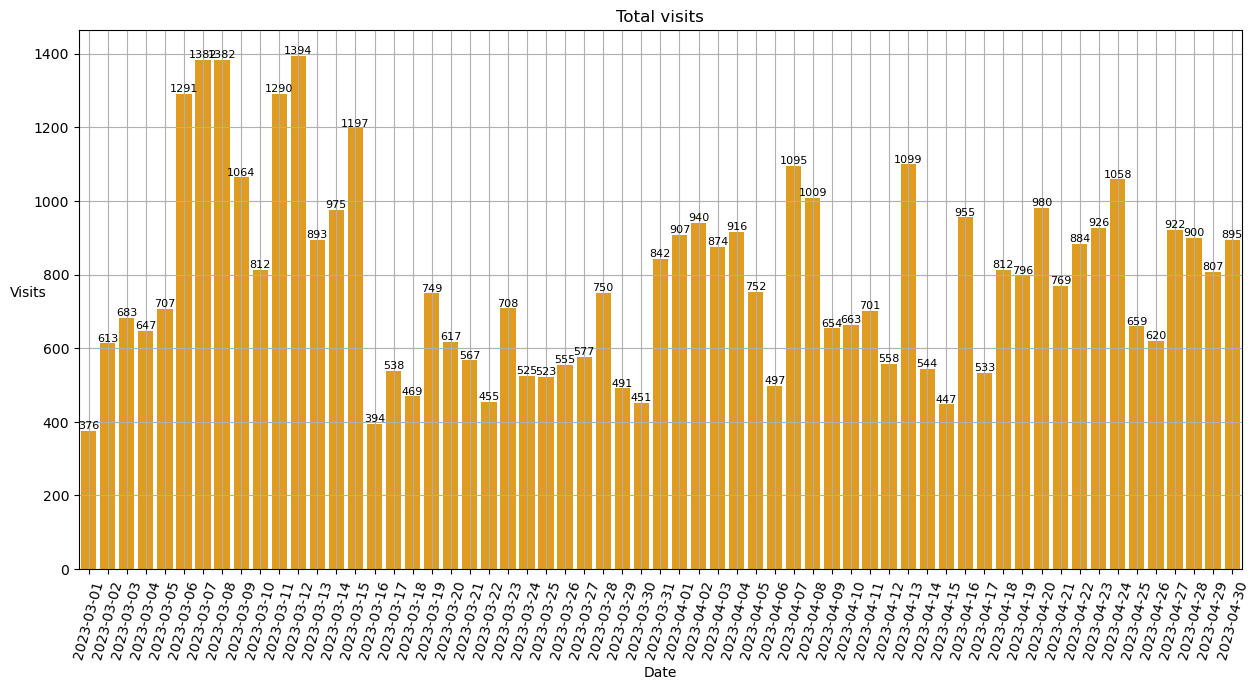

In [27]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.barplot(x="date_group", y="visits", data=filtered_visits, color="orange")
ax.bar_label(ax.containers[0], fontsize=8)
plt.xticks(rotation=75)
plt.xlabel("Date")
plt.ylabel("Visits", rotation=360)
plt.title("Total visits")
plt.grid()
plt.savefig("./charts/final_visits_barplot.png")
plt.show()


### Итоговые визиты с разбивкой по платформам: web, android, ios

In [28]:
visits_by_platform = conversion_df.groupby(["date_group", "platform" ]).agg({"visits":"sum"}).reset_index() #подготовка данных
visits_by_platform["date_group"] = pd.to_datetime(visits_by_platform["date_group"])
filtered_visits_by_platform = visits_by_platform[visits_by_platform['date_group'] <= date_limit]

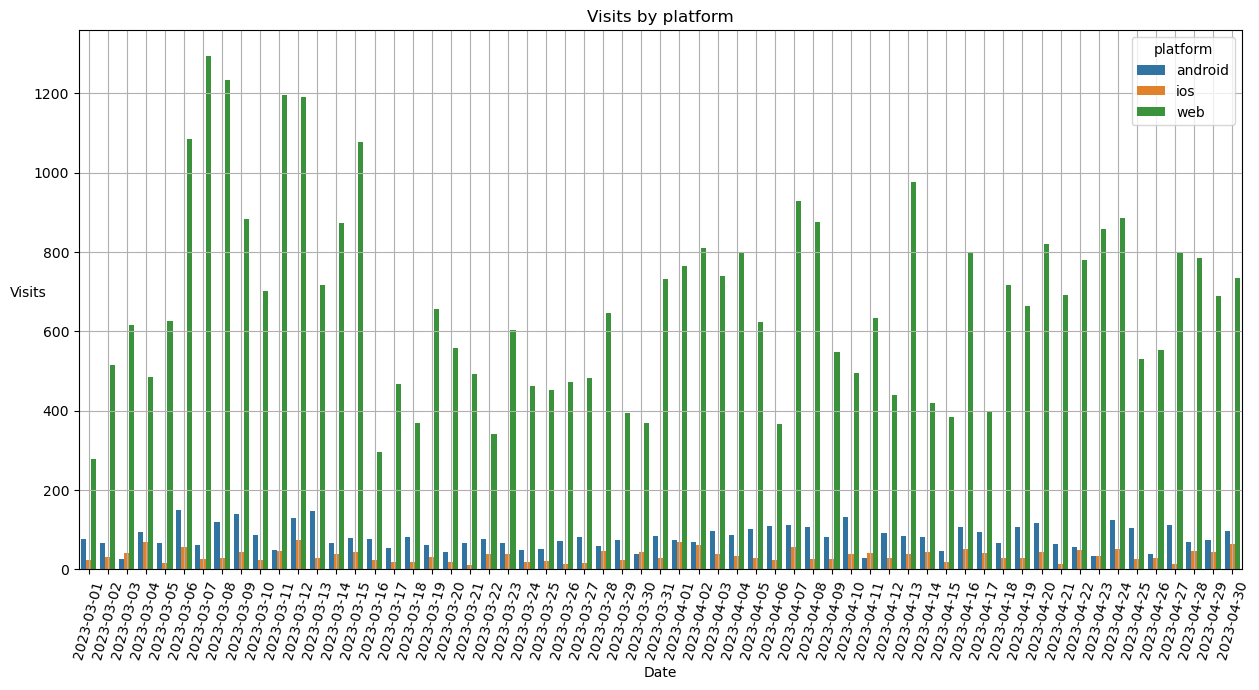

In [29]:
plt.figure(figsize=(15, 7))
sns.barplot(x="date_group", y="visits", hue="platform", data=filtered_visits_by_platform)
plt.xlabel("Date")
plt.ylabel("Visits", rotation=360)
plt.title("Visits by platform")
plt.xticks(rotation=75)
plt.grid()
plt.savefig('./charts/final_visits_by_platform_chart.png')
plt.show()

## Итоговые регистрации

In [30]:
total_regs = ads.groupby(["date_group"]).agg({"registrations":"sum"}).reset_index() #подготовка данных
total_regs["date_group"] = pd.to_datetime(total_regs["date_group"])
filtered_regs = total_regs[total_visits["date_group"] <= date_limit]

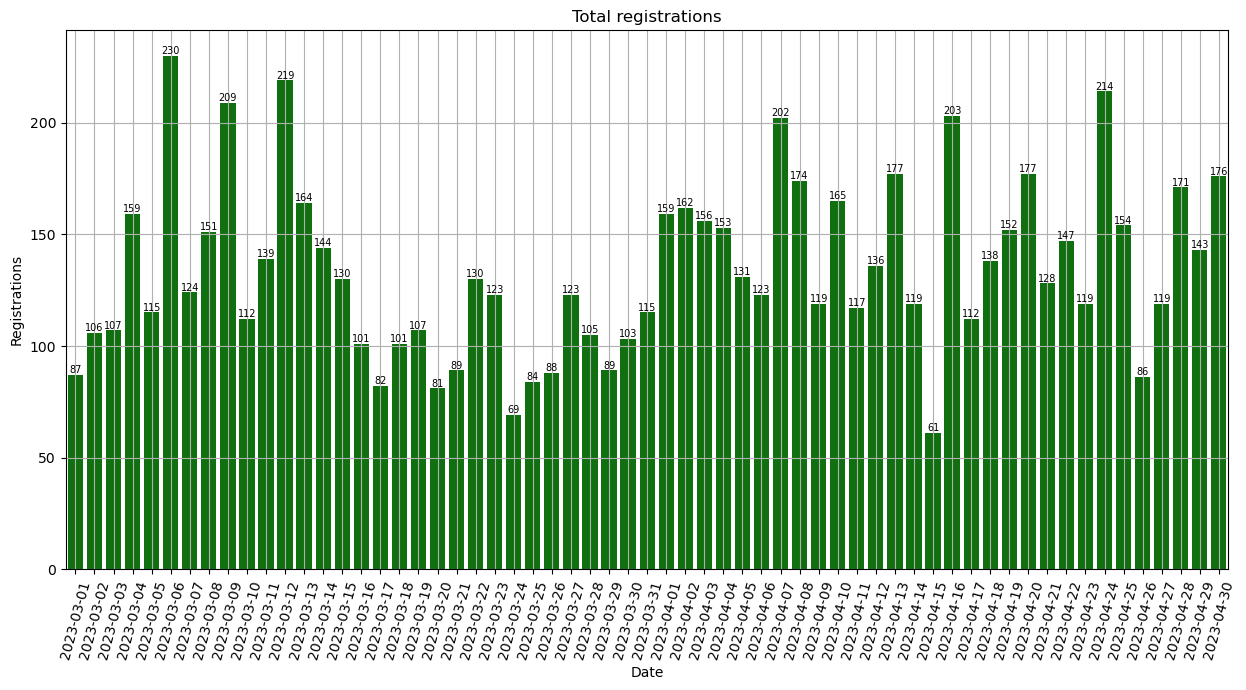

In [31]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.barplot(x="date_group", y="registrations", data=filtered_regs, color="green")
ax.bar_label(ax.containers[0], fontsize=7)
plt.xticks(rotation=75)
plt.xlabel("Date")
plt.ylabel("Registrations")
plt.title("Total registrations")
plt.grid()
plt.savefig("./charts/final_regs_barplot.png")
plt.show()

## Регистрации по платформам

In [32]:
regs_by_platform = conversion_df.groupby(["date_group", "platform"]).agg({"registrations":"sum"}).reset_index() #подготовка данных
regs_by_platform["date_group"] = pd.to_datetime(regs_by_platform["date_group"])
filtered_regs_by_platform = regs_by_platform[regs_by_platform['date_group'] <= date_limit]

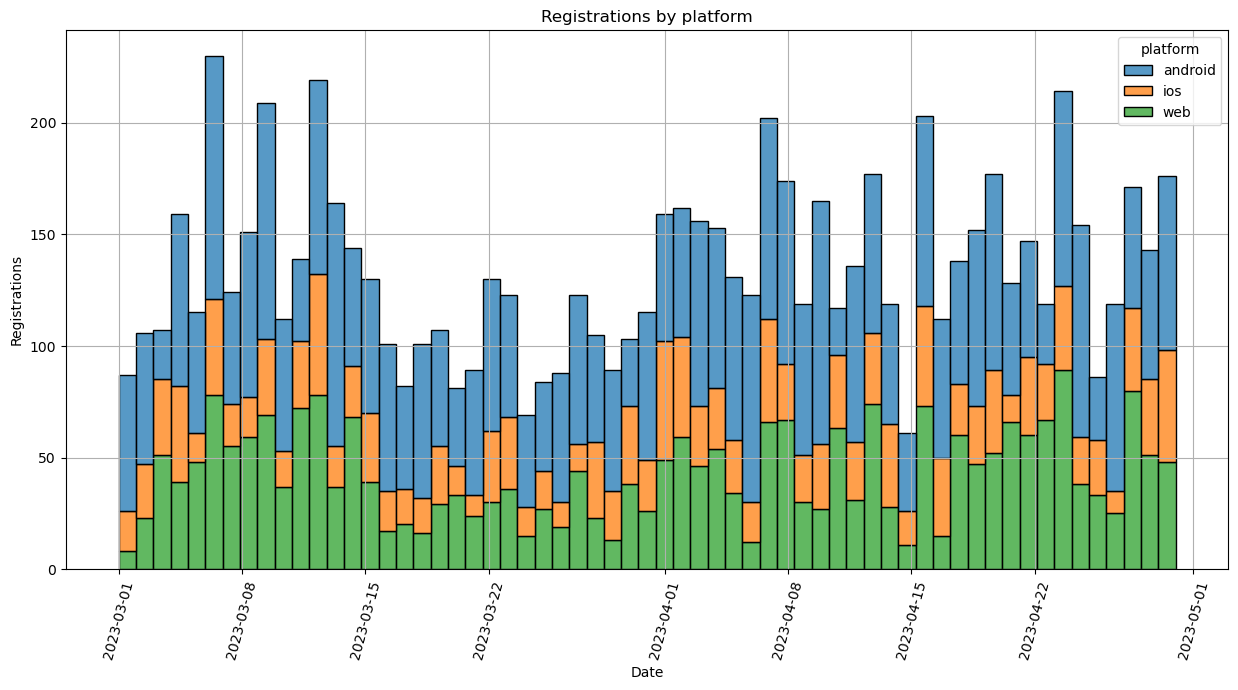

In [33]:
plt.figure(figsize=(15, 7))
sns.histplot(x="date_group", weights="registrations", hue="platform", data=filtered_regs_by_platform, multiple="stack", bins=len(filtered_regs_by_platform["date_group"].unique()))
plt.xlabel("Date")
plt.ylabel("Registrations")
plt.title("Registrations by platform")
plt.xticks(rotation=75)
plt.grid()
plt.savefig('./charts/final_registrations_by_platform_barplot.png')
plt.show()

## Конверсии по платформам

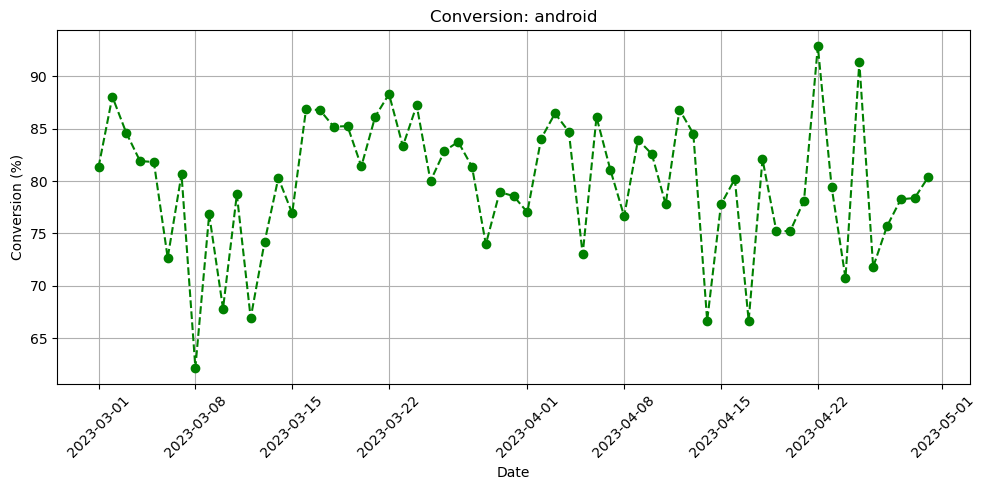

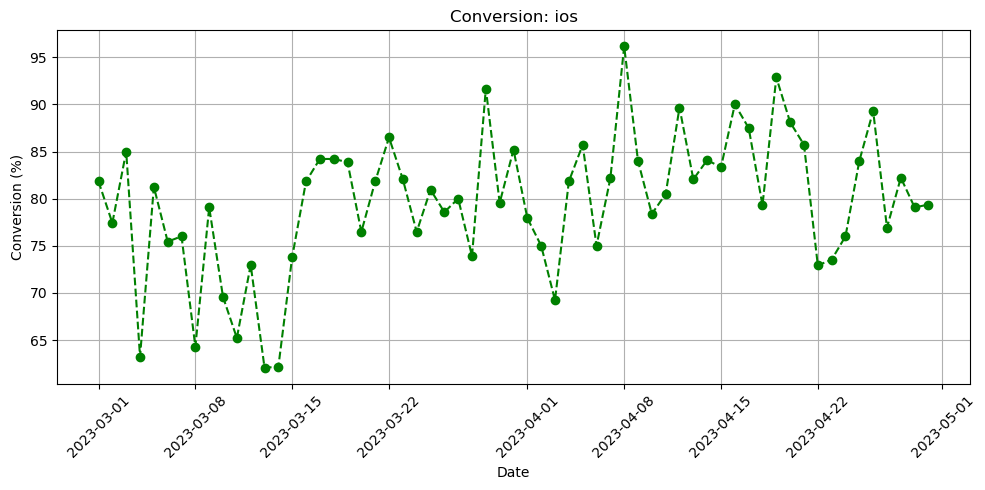

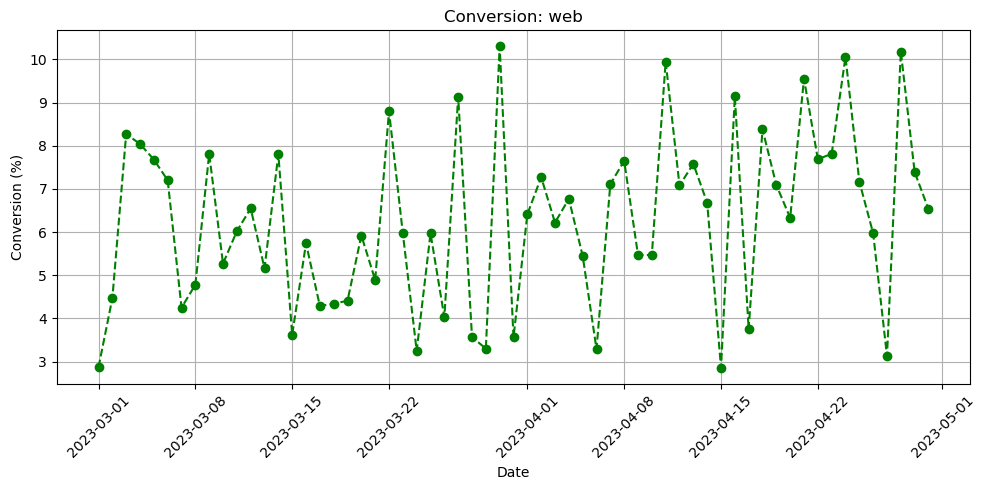

In [34]:

conversion_df["date_group"] = pd.to_datetime(conversion_df["date_group"])
platforms = conversion_df["platform"].unique()

for platform in platforms:
    subset = conversion_df[conversion_df["platform"] == platform]
    subset = subset[subset["date_group"] <= date_limit] 

    plt.figure(figsize=(10,5))
    plt.plot(subset["date_group"], subset["conversion"], marker="o", linestyle="dashed", color="green")
    plt.title(f"Conversion: {platform}")
    plt.xlabel("Date")
    plt.ylabel("Conversion (%)")
    plt.xticks(rotation=45)
    plt.grid()
    plt.tight_layout()
    plt.savefig(f"./charts/conversion_{platform}.png")
    plt.show()

## Средняя конверсия

In [35]:
mean_conversion = conversion_df.groupby("date_group").agg({"conversion":"mean"}).reset_index() #подготовка данных

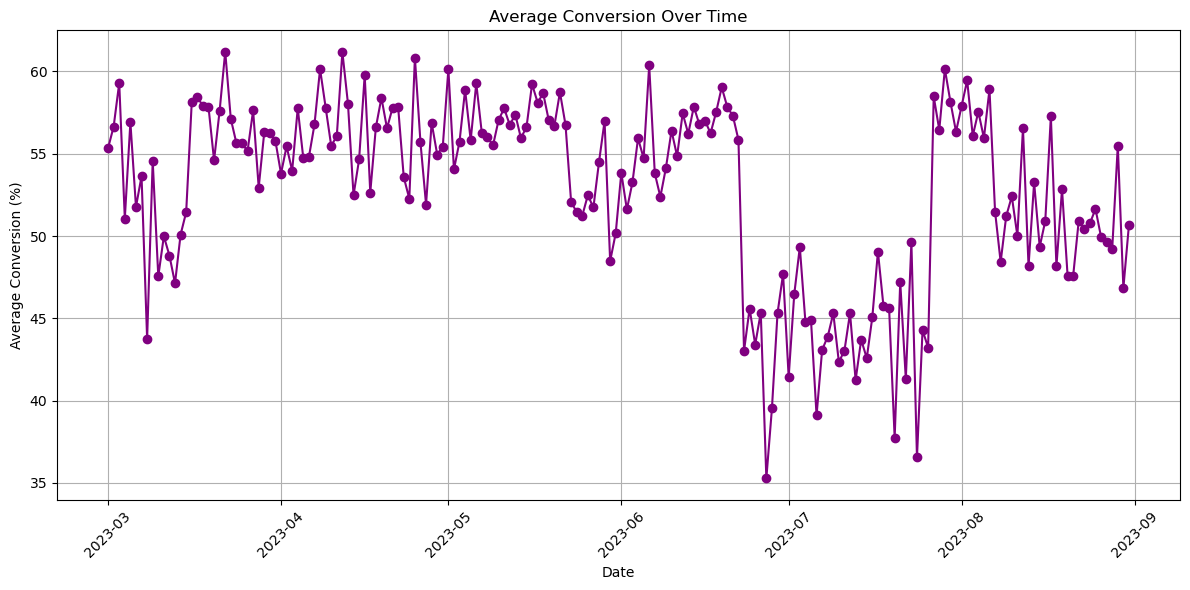

In [36]:
plt.figure(figsize=(12,6))
plt.plot(mean_conversion["date_group"], mean_conversion["conversion"], marker="o", color="purple")
plt.title("Average Conversion Over Time")
plt.xlabel("Date")
plt.ylabel("Average Conversion (%)")
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.savefig("./charts/avg_conversion.png", dpi=150)
plt.show()


## Стоимость реклам

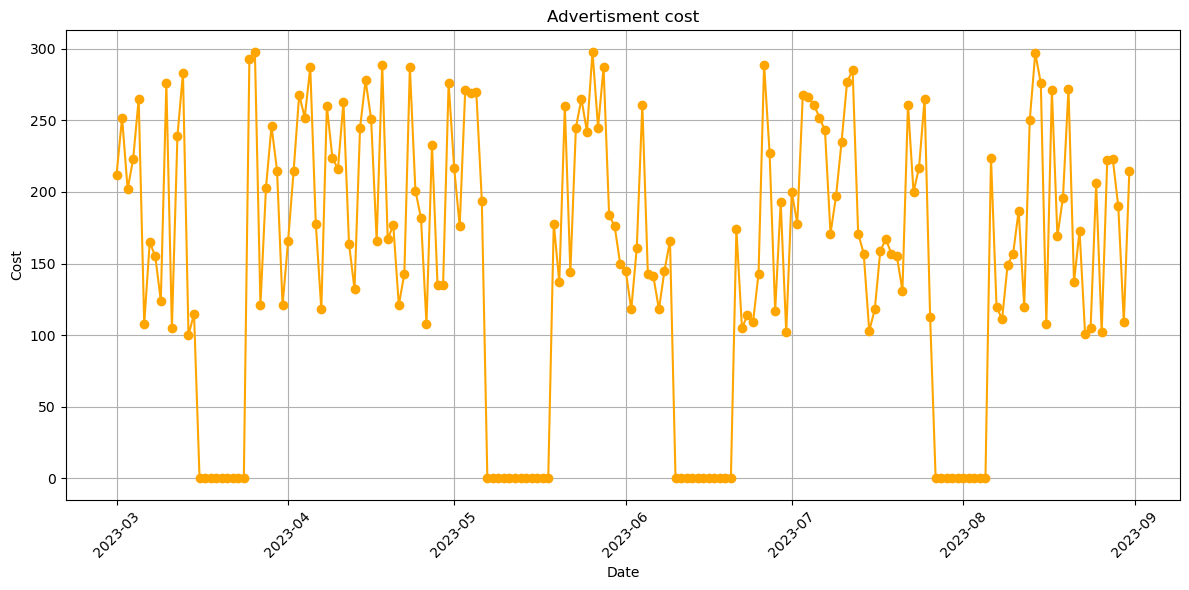

In [37]:
daily_costs = (ads.groupby("date_group", as_index=False)["cost"].sum())
plt.figure(figsize=(12,6))
plt.plot(daily_costs["date_group"], daily_costs["cost"], marker="o", color="orange")
plt.title("Advertisment cost")
plt.xlabel("Date")
plt.ylabel("Cost")
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.savefig("./charts/ads_costs_total.png")
plt.show()

## Визиты за весь период с цветовым выделением рекламной кампании

In [38]:
daily_metrics = (conversion_df.groupby("date_group", as_index=False)[["visits", "registrations"]].sum()) #подготовка данных
daily_metrics["date_group"] = pd.to_datetime(daily_metrics["date_group"]).dt.date
ads["date_group"] = pd.to_datetime(ads["date_group"]).dt.date

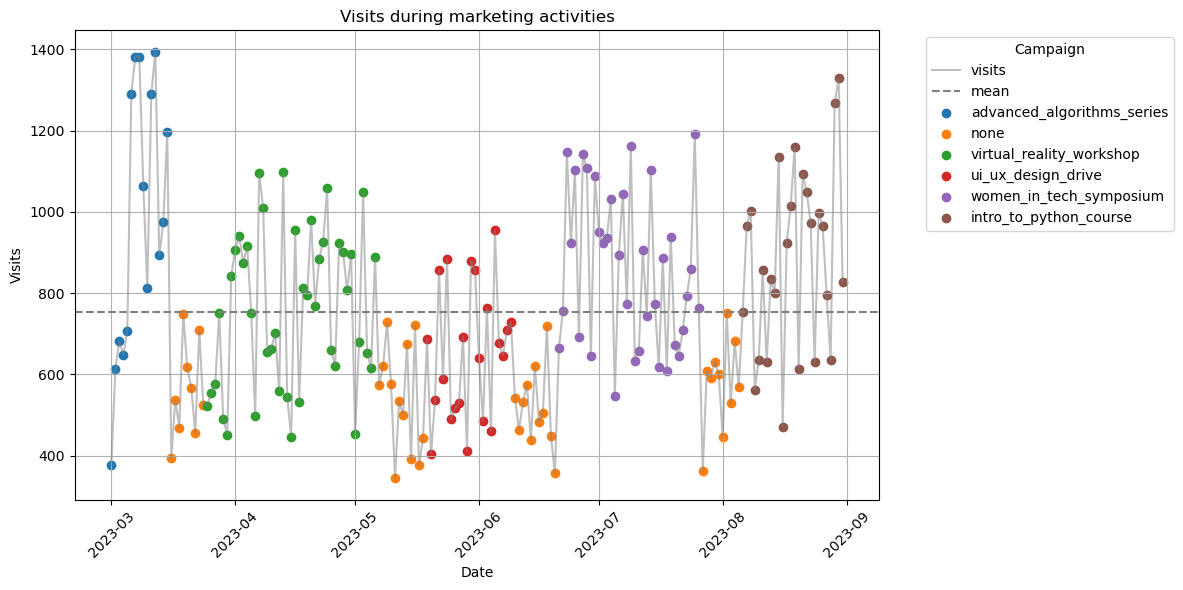

In [39]:
visits_with_ads = daily_metrics.merge(
    ads[["date_group", "utm_campaign"]].drop_duplicates(),
    on="date_group",
    how="left"
).fillna({"utm_campaign": "none"})

plt.figure(figsize=(12,6))

plt.plot(visits_with_ads["date_group"], visits_with_ads["visits"], color="gray", alpha=0.5, label="visits")

avg_vis= visits_with_ads["visits"].mean()
plt.axhline(avg_vis, color="grey", linestyle="--", label= "mean")


for campaign in visits_with_ads["utm_campaign"].unique():
    subset = visits_with_ads[visits_with_ads["utm_campaign"] == campaign]
    plt.scatter(subset["date_group"], subset["visits"], label=campaign)

plt.title("Visits during marketing activities")
plt.xlabel("Date")
plt.ylabel("Visits")
plt.xticks(rotation=45)
plt.legend(title="Campaign", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid()
plt.tight_layout()
plt.savefig("./charts/visits_with_campaigns.png", dpi=150)
plt.show()

## Регистрации за весь период с цветовым выделением рекламной кампании

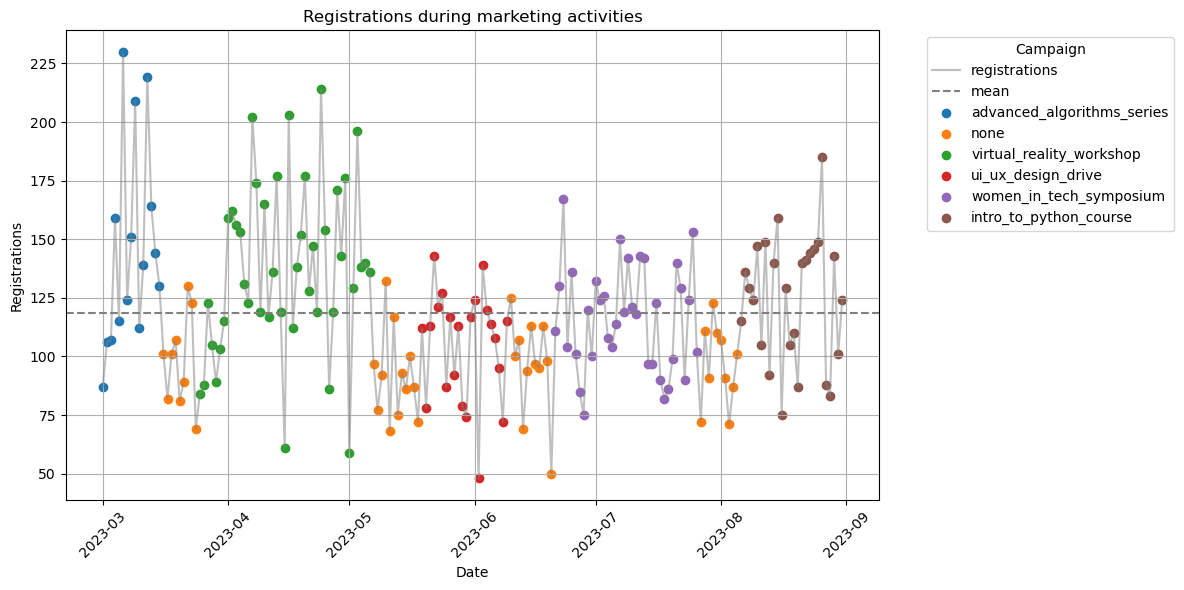

In [40]:
regs_with_ads = daily_metrics.merge(
    ads[["date_group", "utm_campaign"]].drop_duplicates(),
    on="date_group",
    how="left"
).fillna({"utm_campaign": "none"}) #подготовка данных

plt.figure(figsize=(12,6))

plt.plot(regs_with_ads["date_group"], regs_with_ads["registrations"], color="gray", alpha=0.5, label="registrations")

avg_regs = regs_with_ads["registrations"].mean()
plt.axhline(avg_regs, color="grey", linestyle="--", label= "mean")

for campaign in regs_with_ads["utm_campaign"].unique():
    subset = regs_with_ads[regs_with_ads["utm_campaign"] == campaign]
    plt.scatter(subset["date_group"], subset["registrations"], label=campaign)

plt.title("Registrations during marketing activities")
plt.xlabel("Date")
plt.ylabel("Registrations")
plt.xticks(rotation=45)
plt.legend(title="Campaign", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid()
plt.tight_layout()
plt.savefig("./charts/registrations_with_campaigns.png")
plt.show()